# Homework 3 - Name, SCIPER

In this homework, we are going to work with the transformer. There are three parts of this homework.

- In the first part, we are going to implement **positional encoding** and **self-attention**  and test them on a simple text dataset which contains around 100 sentences. We will use a small transformer in this task.

- In the second part, we will detect promoters from the DNA sequences. The main difference compared to the previous task is to tokenize the DNA sequence. Thus, our task here is to build the **tokenizer** to tokenize the DNA sequence. For the model, we will continue using the small transformer.

- In the third part, we will use a **foundation model** DNABERT to perform promoter detection. In this part, you do not need to train the transformer. Instead, you need to find and load the correct pre-trained model and then use it to get the embedding of the DNA sequence. Then, you will build a simple classifier to perform promoter detection based on the DNA embedding.



## 0. Initialization

Import the packages you are going to use here.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
import numpy as np

import ipywidgets as widgets
from types import SimpleNamespace
from utils import data, evaluation, models, visualization, text_exercise

import math

Set the hyperparameters.

In [2]:
# Set seeds
seed = 128
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.mps.manual_seed(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")
device = "cpu"
print(f"Using device: {device}")

Using device: cpu


## 1. Positional Encoding and Self-Attention (7 pts)

### 1.1. Sinusoidal Positional Encoding (1 pt)

In this section, you are going to implement the sinusoidal positional encoding. The formula is as the following:

<div>
<img src="./imgs/positional embedding.png" width="400"/>
</div>

where $t$ is the desired position in the input and $\mathsf{\omega}_k$ follows:

<div>
<img src="./imgs/omega.png" width="200"/>
</div>

To see the details of sinusoidal positional encoding, you can check this [link](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

---

Positional encodings assigns a vector to each token position in the input sequence and is added to the embedding of the token itself. For the element-wise addition to work, we are seeking for a tensor that matches the shape of the embedding tensor. In this case, the positional encoding tensor should have the shape of (seq_len, d_model), which are denoted as `max_position_embedding` and `hidden_size` respectively. For any position $t$ and vector index $i$, the positional encoding is defined as:

$$
\begin{align*}
PE_{t, 2i} &:= sin(\frac{t}{10000^{{2i}/{d_{model}}}}) \\
PE_{t, 2i+1} &:= cos(\frac{t}{10000^{{2i}/{d_{model}}}}) \\
\end{align*}
$$

As we can see, the positional encoding tensor is composed of two parts: the sine part and the cosine part. The sine part is for the even indices and the cosine part is for the odd indices. We realise that the two parts share the input into the trigonometric functions. Thus, we first compute $w_k \cdot t$ and then use the result to compute the sine and cosine parts and assign them to the even and odd index positions in the positional encoding tensor respectively.

In [3]:
class PositionalEmbedding(nn.Module):
    """Returns the positional embedding for inputs of a maximum sequence length and dimension."""

    def __init__(self, max_position_embeddings, hidden_size, device):
        """
        Initialises the PositionalEmbedding class.

        Args:
            max_position_embeddings (int): maximum length of the input - related to t in the previous formula
            hidden_size (int): encoding dimension - d in the previous formula
            device (torch.device): device on which to store the positional embedding
        """
        super().__init__()

        # Save parameters
        self.max_position_embeddings = max_position_embeddings
        self.hidden_size = hidden_size

        # Compute positional embeddings
        t = torch.arange(max_position_embeddings, device=device).unsqueeze(1)

        even_hidden_size = hidden_size % 2 == 0
        self.positional_embedding = torch.zeros(max_position_embeddings, hidden_size, device=device)
        if even_hidden_size:
            w = 1 / (10000 ** (2 * torch.arange(0, hidden_size, 2, device=device) / hidden_size))
            self.positional_embedding[:, 0::2] = torch.sin(t * w)
            self.positional_embedding[:, 1::2] = torch.cos(t * w)
        else:
            w = 1 / (10000 ** (torch.arange(0, hidden_size, 2, device=device) / hidden_size))
            self.positional_embedding[:, 0::2] = torch.sin(t * w)
            self.positional_embedding[:, 1::2] = torch.cos(t * w[:-1])

    def forward(self, x):
        return self.positional_embedding

    def embedding(self):
        return self.positional_embedding

Here, you can visualize your positional encoding. If you implement everything correctly, you can get a figure that is similar to Figure 2 in this [link](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

In [4]:
(
    visualize_embedding,
    dimension_selector,
    max_len_selector,
) = visualization.display_positional_encoding(PositionalEmbedding)
ui = widgets.HBox([max_len_selector, dimension_selector])
out = widgets.interactive_output(
    visualize_embedding, {"max_len": max_len_selector, "dimension": dimension_selector}
)
display(ui, out)

Output()

### 1.2. Self-Attention Mechanism (5 pts)

In this section, you are going to implement the self-attention mechanism. Please check the section 'Self-Attention in Detail' in this [link](https://jalammar.github.io/illustrated-transformer/) for the details of self-attention mechanism. (We encourage you to carefully go through the link since it is a very good tutorial for transformer.)

The specific steps will be provided in the comments of the following code. (The steps are only for reference. You do need to follow the steps if you have a better way to implement it.)

---

The `BertSelfAttention` layer uses a single query, key and value matrix that combines the matrices of all the different heads. Thus, to initialise the matrices, we use the combined head size as the output dimensions, and then split the output into the different heads to perform the scaled dot product attention.

In [5]:
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )

        # Save configuration parameters
        self.hidden_size = config.hidden_size
        self.output_attentions = config.output_attentions
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Initialise attention weights matrices of all heads in a single linear layer
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        # Add dropout layer
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        """
        Permutes an input tensor from (batch_size, seq_len, all_head_size) to
        (batch_size, num_heads, seq_len, head_size)
        """
        new_x_shape = x.size()[:-1] + (
            self.num_attention_heads,
            self.attention_head_size,
        )
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
    ):
        """
        Applies self-attention to a batch of input sequences.

        NB: The encoder_hidden_states and encoder_attention_mask are for cross-attention
        and are not used here.

        Args:
            hidden_states (torch.Tensor): input tensor of shape (batch_size, seq_len, hidden_size)
            attention_mask (torch.Tensor): attention mask of shape (batch_size, seq_len)
            head_mask (torch.Tensor): mask to nullify selected heads of shape (num_heads,)

        Returns:
            torch.Tensor: output tensor of shape (batch_size, seq_len, hidden_size)
            torch.Tensor (optional): attention scores of shape (batch_size, num_heads, seq_len, seq_len)
        """
        # Save dimensions of input shape
        B, N, H = hidden_states.shape

        # Compute the query, key, value matrices in all heads
        # Output dimension: (num_batches, seq_len, num_heads * head_size) = (num_batches, seq_len, all_head_size)
        mixed_key_layer = self.query(hidden_states)
        mixed_query_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        # Transpose K, Q, V to get the queries, keys and values in each head
        # Output dimension: (num_batches, num_heads, seq_len, head_size)
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Compute attention scores through scaled dot product attention
        attention_scores = query_layer @ key_layer.transpose(-1, -2) / math.sqrt(self.hidden_size)

        # You do not need to change this part.
        # Apply attention mask
        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities (+ dropout)
        attention_probs = self.dropout(F.softmax(attention_scores, dim=-1))

        # You do not need to change this part.
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        # Compute output as weighted sum of value by the score
        context_layer = attention_probs @ value_layer

        # Permute context layer back to original shape
        context_layer = context_layer.view(B, N, H)

        # Get the output
        outputs = (
            (context_layer, attention_probs)
            if self.output_attentions
            else (context_layer,)
        )
        return outputs

Let's test your implementation using simple text data! First, let's load the data.

We use a small dataset in this homework for a shorter training time.

In [6]:
# ChatGPT generated text data about BERT
text = text_exercise.get()
sentences_df, vocab = data.to_sentence_df(text)

Let's have a quick look at some of the samples in the dataset.

In [7]:
sentences_df.head(5)

,sequence
0,transformers change how we deal with language
1,they help machines understand text
2,they read words and see patterns
3,patterns help them learn
4,learning like this was hard before


In [8]:
num_sentences = len(sentences_df)
avg_sentence_len = np.array([len(seq) for seq in sentences_df.sequence]).mean()

print(f"Number of sentences: {num_sentences}")
print(f"Avg. number of characters per sentence: {avg_sentence_len:.2f}")

Number of sentences: 97
Avg. number of characters per sentence: 31.35


We see that the dataset only consits of 97 small sentences, having an average character length of ~30. This is a very small dataset, and we expect our model to quickly overfit on it.

After loading the data, you can train your model. Here we train our model using masked token prediction.

Hint: The final model accuracy should be higher than 0.9.

In [9]:
text_max_len = 11

text_config = SimpleNamespace(
    vocab_size=len(vocab),
    hidden_size=60,
    max_position_embeddings=text_max_len,
    type_vocab_size=1,
    layer_norm_eps=1e-12,
    hidden_dropout_prob=0.0,
    attention_probs_dropout_prob=0.0,
    num_attention_heads=1,
    hidden_act="gelu",
    intermediate_size=160,
    num_hidden_layers=1,
    is_decoder=False,
    output_attentions=True,
    output_hidden_states=False,
    pruned_heads={},
    initializer_range=0.02,
    device="cpu",
)

# Toknise the sentences
tokenizer = data.TextTokenizer(vocab)

# Generate masked training data
(input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks) = data.generate_masked_data(sentences_df, tokenizer, k=1, max_len=text_max_len, noise_rate=0.4)

# Initialise model and optimiser
model = models.BertForMaskedLM(config=text_config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

# Training loop
for epoch in range(200):
    optimizer.zero_grad()
    loss, outputs, attentions = model(
        input_ids=input_ids,
        token_type_ids=segment_ids,
        masked_lm_labels=masked_lm_labels,
        attention_mask=attention_masks,
    )
    if (epoch + 1) % 20 == 0:
        print("Epoch:", "%03d" % (epoch + 1), "loss =", "{:.6f}".format(loss))
    loss.backward()
    optimizer.step()

print(f"Final model accuracy: {(100 * evaluation.masked_label_accuracy(labels, labels_idx, outputs.data)):.2f}%")

Number of trainable model parameters: 64910
Epoch: 020 loss = 4.348363
Epoch: 040 loss = 3.709610
Epoch: 060 loss = 3.159281
Epoch: 080 loss = 2.636598
Epoch: 100 loss = 2.183997
Epoch: 120 loss = 1.766478
Epoch: 140 loss = 1.347228
Epoch: 160 loss = 0.979548
Epoch: 180 loss = 0.601086
Epoch: 200 loss = 0.364616
Final model accuracy: 99.22%


Nice, we can (over-)fit to ~100% training accuracy very quickly. This is to be expected given the small dataset size. Let's visualise what the model has learned by inspecting the attention weights for each sample.

### 1.3. Visualize Attention (1 pt)

Here, you can visualize the self-attention. 

Question: Can you interpret the visualization of the self-attention?

**Write down you answer here (1 pt):** The visualisation shows a heatmap of the attention weight matrix in the self-attention head in the hidden layer of the BERT model trained above. Each sample is associated with a $11 \times 11$ matrix showing the relative importance of tokens within the sequence to each other. Specifically, the element $a_{uv}$ shows the importance of the $v$-th token to the $u$-th token, where darker colours signalise higher importance.

Generally, the attention weight matrix is an insightful tool to understand which tokens are relevant for predicting the masked tokens and show the intricate natural language patterns learned for a specific task. Typically, one can see that the attention weights are concentrated on the diagonal (localised attention), which means that the model attends to the tokens in the same position in the input and output sequence with some global dependencies if a token has important information for the prediction of a masked token in a far-away position.

However, inspecting the attention matrix from the above BERT model trained on the tiny corpus of less than 100 short sentences shows none of these typicaly behaviours. Instead, we observe signs of overfitting and data memorisation. Specifically, the attention weights are concentrated in one or a few columns for most samples. These overly sharp attention peaks signalise that the model is overly relying on specific tokens for its predictions. Instead of learning general patterns, it simply memorises the structure of the training data and the position of specific tokens in the training data. These findings align with the fact that we are dealing with a very small dataset that we quickly overfit to 100% training accuracy in 200 epochs.

In [10]:
visualize_attention, sample_id_selector = visualization.display_attantion(
    attentions=attentions, input_ids=input_ids, tokenizer=tokenizer
)
widgets.interactive(visualize_attention, sample_id=sample_id_selector)

interactive(children=(Dropdown(description='Sample:', options=(5, 8, 11, 13, 18, 24, 26, 29, 31, 35, 37, 38, 6…

### 1.4. Train on small Wikitext Dataset

Here, you can **optionally** test your model on the smallest wikitext dataset. You should get an test accuracy around 0.4 after training 50 epochs.

This part is only for you to test your code. You can choose to run it or not. It takes around 1 hour to train the model for 50 epochs on the smallest wikitext dataset with Google Colab.

In [11]:
# Don't train
# text_exercise.train_wikitext(device, positional_embedding=PositionalEmbedding, attention=BertSelfAttention)

## 2. Promoter detection (7 pts)

In this section, we detect promoter in DNA sequence.

A promoter is a region of DNA upstream of a gene where relevant proteins (such as RNA polymerase and transcription factors) bind to initiate transcription of that gene. Promoter detection is to identify if there are promoter regions in the given DNA sequence. We have covered this in the lecture. (If you are interested in the promoter, you can check this [link](https://www.genome.gov/genetics-glossary/Promoter) for more details.)

Here, we use a transformer and a classifier. The transformer first embeds the DNA sequences into features, and then the classifier detects the promoter based on the features.

The main difference between text and DNA sequence is how to tokenize the sequence. Thus, you need to implement a tokenizer for the DNA sequence.

### 2.1. DNA Tokenizer (1 pts)

Here, you will implement the DNA tokenizer the same as in DNABERT. Please check this [paper](https://academic.oup.com/bioinformatics/article/37/15/2112/6128680) for implementation details. Also, you need to check the data type and shape for both input and output.

---

The `DNATokenizer` inherits from the `Tokenizer` class which already provides a lot of functionality for the tokenisation of DNA sequences. All we are left to implement is to split a single DNA sequence into a list of overlapping k-mers inside the `_parse_text` function. To implement, we iterate over the nucleotides in the DNA sequence and add the $k$-mer starting at the current position to the list of tokens. We do not need to handle special tokens such as class tokens, padding or unknown tokens as these are already handled by the `Tokenizer` class.

In [12]:
class DNATokenizer(data.Tokenizer):
    def __init__(self, k, vocab, unknown="[UNK]"):
        """
        DNA tokenizer that splits a DNA sequence into k-mers. Inherits from
        data.Tokenizer which implements functionality for mapping the parsed tokens
        to indices and vice versa.
        """
        super().__init__(vocab, unknown)
        # Save parameters
        self.k = k

    def _parse_text(self, text):
        """
        Parse a text into a list of tokens.

        Args:
            text (str): text to parse

        Returns:
            list[str]: list of k-mer token strings
        """
        return [text[i : i+self.k] for i in range(len(text) - self.k+1)]

### 2.2. Test BERT on DNA Sequence

In this section, you will train BERT on DNA sequence to learn the embedding of DNA sequence. The code is provided below and you do not need to write anything.

Hint: the final evaluation accuracy should be higher than 0.2.

In [13]:
# Initialise vocabulary
kmer = 3
mask_length = kmer
VOCAB_3MER = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "AAA", "AAT", "AAC", "AAG", "ATA", "ATT", "ATC", "ATG", "ACA", "ACT", "ACC", "ACG", "AGA", "AGT", "AGC", "AGG", "TAA", "TAT", "TAC", "TAG", "TTA", "TTT", "TTC", "TTG", "TCA", "TCT", "TCC", "TCG", "TGA", "TGT", "TGC", "TGG", "CAA", "CAT", "CAC", "CAG", "CTA", "CTT", "CTC", "CTG", "CCA", "CCT", "CCC", "CCG", "CGA", "CGT", "CGC", "CGG", "GAA", "GAT", "GAC", "GAG", "GTA", "GTT", "GTC", "GTG", "GCA", "GCT", "GCC", "GCG", "GGA", "GGT", "GGC", "GGG" ]

# Load raw training data
raw_training_data = data.load_csv("./data/train.csv")
raw_test_data = data.load_csv("./data/test.csv")

dna_max_len = 298
batch_size = 128
max_dna_mask = 100
dataset_size = 1000
num_layers = 3
num_heads = 6
dna_config = SimpleNamespace(
        vocab_size=len(VOCAB_3MER),
        hidden_size=60,
        max_position_embeddings=dna_max_len,
        type_vocab_size=1,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        num_attention_heads=num_heads,
        hidden_act="gelu",
        intermediate_size=160,
        num_hidden_layers=num_layers,
        is_decoder=False,
        output_attentions=True,
        output_hidden_states=True,
        pruned_heads = {},
        initializer_range=0.02,
        device=device
    )

# Initialise tokeniser and generate training/ validation data
tokenizer = DNATokenizer(k=kmer, vocab=VOCAB_3MER)
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(raw_training_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)
test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks = data.generate_masked_data(raw_test_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)

# Initialise model and optimiser
model = models.BertForMaskedLM(config=dna_config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention)
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.005)
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

# Initialise training dataset and loader
train_dataset = TensorDataset( input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialise training dataset and loader
test_dataset = TensorDataset(
    test_input_ids,
    test_segment_ids,
    test_masked_lm_labels,
    test_labels_idx,
    test_labels,
    test_attention_masks,
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train model
for epoch in range(50):
    # Training loop
    total_train_loss = 0
    model.train()
    for (batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask,) in train_loader:
        optimizer.zero_grad()
        loss, outputs, hidden_states, _ = model(
            input_ids=batch_input_ids.to(device),
            token_type_ids=batch_segment_ids.to(device),
            masked_lm_labels=batch_masked_lm_labels.to(device),
            attention_mask=batch_attention_mask.to(device),
        )
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    # Evaluation loop
    if (epoch + 1) % 10 == 0:
        model.eval()
        total_eval_loss = 0
        for (batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask,) in test_loader:
            with torch.no_grad():
                loss, outputs, hidden_states, _ = model(
                    input_ids=batch_input_ids.to(device),
                    token_type_ids=batch_segment_ids.to(device),
                    masked_lm_labels=batch_masked_lm_labels.to(device),
                    attention_mask=batch_attention_mask.to(device),
                )
                if batch_attention_mask.sum() - torch.numel(batch_attention_mask) > 0:
                    print("found patting", batch_attention_mask.sum())
                total_eval_loss += loss.item()
        avg_eval_loss = total_eval_loss / len(test_loader)
        print("Epoch:", "%04d" % (epoch + 1), 
              "train cost =", "{:.6f}".format(avg_train_loss), 
              "eval cost =", "{:.6f}".format(avg_eval_loss))

# Compute average traininga and evaluation accuracy
average_train_acc, _ = evaluation.model_masked_label_accuracy(model, train_loader, device)
average_test_acc, last_test_attention = evaluation.model_masked_label_accuracy(model, test_loader, device)
print("Train Acc =", "{:.2f}%".format(100 *average_train_acc), "Eval Acc =", "{:.2f}%".format(100 * average_test_acc))

Number of trainable model parameters: 118869
Epoch: 0010 train cost = 4.033949 eval cost = 4.070072
Epoch: 0020 train cost = 3.856980 eval cost = 4.031624
Epoch: 0030 train cost = 3.118403 eval cost = 3.395089
Epoch: 0040 train cost = 1.693766 eval cost = 2.102110
Epoch: 0050 train cost = 1.384483 eval cost = 2.288412
Train Acc = 47.43% Eval Acc = 23.80%


Nice, we are able to train to **>20%** evaluation accuracy. Note that I slightly had to increase the leraning rate to **0.005** for faster convergance.

### 2.3. Visualize the Attentions (1 pt)

Here, you can visualize the self-attention. 

Question: compare the visualization to Section 1.3, what can you find here? How do you explain it?

**Write down you answer here (1 pt):** This time we are training on a significantly larger training dataset of DNA sequences. This time we are training a larger model with **3** encoder blocks each consisting of **6** attention heads in the multi-headed self-attention. Further, we are considering larger context size of 298 tokens. Thus, for each DNA sequence sample we can visualise the attention weights of each of the 6 attention heads in each of the 3 encoder blocks. Firstly, we observe that each head is responsible for the attention of a subset of the tokens (e.g. the first head contains attentions of the first `head_size` tokens, the second head of the next `head_size` and so on). Within the attention of each head, we observe the typical local dependencies along the diagonal, signalising that for most k-mers the near neighbourhood is most informative to make a prediction which aligns with the expectation.

In [14]:
visualize_attention, sample_id_selector, layer_selector, head_selector = \
    visualization.display_multi_attantion(
        attentions=last_test_attention,
        tokenizer=tokenizer,
        input_ids=input_ids,
        layers=range(1, num_layers + 1),
        heads=range(1, num_heads + 1),
    )
ui = widgets.HBox([sample_id_selector, layer_selector, head_selector])
out = widgets.interactive_output(
    visualize_attention,
    {"sample_id": sample_id_selector, "layer": layer_selector, "head": head_selector},
)
display(ui, out)

Output()

### 2.4. Use your pretrained model for promoter detection (5 pts)

You already have the embeddings for the DNA sequence. Now, you are going to build a classifier based on the DNA embeddings. The classifier is to perform promoter detection. Specifically, the DNA sequence will be classified into *'contains promoter'* or *'does not contain promoter'*.

Hint: 
- We now want to annotate data (get the label for each sample), not predict masked data anymore!
- You can reuse some parts of the code in the previous sections, e.g. dataloader and training pipeline in Section 2.2.
- If you implement the previous section correctly (the Eval Acc > 0.2 in Section 2.2), you already have an pre-trained object named 'model' of class models.BertForMaskedLM. You can directly use it.
- The evaluation accuracy of this task should be around 0.6.

---

We first define a new model `PromoterDetector` which is a binary classification head that is "stacked" on top of a pre-trained DNABERT model. The model assumes that the BERT model is pre-trained and all weights are frozen for faster training.

In [15]:
class PromoterDetector(nn.Module):
    """PromoterDetector classification head on top of DNA BERT."""
    def __init__(self, model):
        """
        Classification head to stack on top of a pre-trained DNABERT model for
        promoter detection. It assumes that all weights inside the pre-trained
        model are frozen for faster fine-tuning.

        Args:
            model (nn.Module): A pre-trained encoder model
        """
        super().__init__()

        # Save parameters
        self.model = model
        self.hidden_size = model.config.hidden_size

        # Initialise linear layer from class token
        self.linear = nn.Linear(self.hidden_size, 1)

    def forward(self, input_ids):
        """
        Feed forward function of the classification head. Returns the logits of the classification
        of each sequence in the batch. Assumes that the hidden states are returned by BERT model
        as the second output. And that the last tensor in the hidden state list corresponds to the
        hidden states in the last encoder block (i.e. the final output of the encoder) and that the
        first token in the sequence is the class token.

        Args:
            input_ids (torch.Tensor): Input tensor of shape (batch_size, seq_len)

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, )
        """

        # Compute BERT output
        _, hidden_states, _ = self.model(input_ids=input_ids)
        
        # Extract last hidden state
        last_hidden_state = hidden_states[-1]

        # Get the embedding of the first token (class token)
        class_tokens = last_hidden_state[:, 0, :]

        # Get the classification logits
        logits = self.linear(class_tokens)

        return logits.squeeze()

Next, we define new dataset classes and loaders which sample the tokenised input indices and sequence labels. We can use the utility function `data.generate_labeled_data` and PyTorch functions for this.

In [16]:
# Generate labelled training data
train_input_ids, train_labels = data.generate_labeled_data(
    raw_training_data,
    tokenizer,
    max_len=dna_max_len,
    max_size=dataset_size,
)

# Generate labelled test data
test_input_ids, test_labels = data.generate_labeled_data(
    raw_test_data,
    tokenizer,
    max_len=dna_max_len,
    max_size=dataset_size,
)

# Convert to PyTorch tensors
train_dataset = TensorDataset(train_input_ids, train_labels)
test_dataset = TensorDataset(test_input_ids, test_labels)

# Create batched data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Let's initialise the `PromotorDetector` from a the pre-trained DNABERT model with frozen weights.

In [17]:
# Freeze all BERT parameters
for params in model.parameters():
    params.requires_grad = False

# Initialise the classifier
clf = PromoterDetector(model).to(device)
optimizer = optim.AdamW(clf.parameters(), lr=0.005)
criterion = nn.BCEWithLogitsLoss()

print(f"Number of model parameters: {models.number_of_model_parameters(clf)}")
print(f"Number of trainable model parameters: {sum([p.numel() for p in clf.parameters() if p.requires_grad])}")

Number of model parameters: 118930
Number of trainable model parameters: 61


We train the model for **50** epochs with a learning rate of **0.005** (*again, slightly increased compared to the original training code*) and print the training and validation loss and accuracy every other epoch.

In [18]:
# Training loop
for epoch in range(50):
    total_train_loss = 0
    model.train()
    for (input_ids, labels) in train_loader:
        # Zero gradients
        optimizer.zero_grad()
        
        # Move data to device
        input_ids = input_ids.to(device)
        labels = labels.to(device).float()

        # Forward pass
        logits = clf(input_ids)
        loss = criterion(logits.squeeze(), labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    if (epoch + 1) % 10 == 0:
        model.eval()
        total_eval_loss = 0
        for (input_ids, labels) in test_loader:
            with torch.no_grad():
                # Move data to device
                input_ids = input_ids.to(device)
                labels = labels.to(device).float()

                # Forward pass and compute loss
                logits = clf(input_ids)
                loss = criterion(logits.squeeze(), labels)

                total_eval_loss += loss.item()

        avg_eval_loss = total_eval_loss / len(test_loader)
        print(
            "Epoch:",
            "%04d" % (epoch + 1),
            "train cost =",
            "{:.6f}".format(avg_train_loss),
            "eval cost =",
            "{:.6f}".format(avg_eval_loss),
        )

Epoch: 0010 train cost = 0.602389 eval cost = 0.681346
Epoch: 0020 train cost = 0.585306 eval cost = 0.690411
Epoch: 0030 train cost = 0.574540 eval cost = 0.695467
Epoch: 0040 train cost = 0.568637 eval cost = 0.699188
Epoch: 0050 train cost = 0.564528 eval cost = 0.703450


Finally, we evaluate the model on the test set using accuracy score.

In [19]:
# Evaluate
y_pred, y_true = [], []
for (input_ids, labels) in test_loader:
    with torch.no_grad():
        # Move data to device
        input_ids = input_ids.to(device)
        labels = labels.to(device).float()

        # Forward pass and compute loss
        logits = clf(input_ids)
        probs = F.sigmoid(logits.squeeze())
        preds = torch.round(probs)

        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

y_pred = torch.Tensor(y_pred)
y_true = torch.Tensor(y_true)
eval_acc = (y_pred == y_true).float().mean()

print("Eval Acc =", "{:.2f}%".format(100 * eval_acc))

Eval Acc = 57.10%


Nice, we are getting **~60%** training accuracy using our custom pre-trained DNA BERT model.

### 2.5. Additional question (1 pt)

Now we change mask_length = 1 (already changed, you do not need to implement anything).
Let's run the code below and check the accuracy.

Question: What is the final masked token prediction accuracy? How do you explain this?

**Write down you answer here (1 pt):**  The `mask_length` parameter controls the number of subsequent k-mers to mask in the input sequence. For `mask_length=1` we mask only one k-mer at a time. Because k-mers are constructed in an overlapping manner the masked language modelling that is performed by the DNA BERT encoder becomes a trivial task because the model has access to all masked nucleotides via the neighbouring k-mers. Thus, we expect the model to quickly be able to reach very high masked token prediction performance.

In [20]:
kmer = 3
mask_length = 1

dna_max_len = 298
batch_size = 128
max_dna_mask = 100
dataset_size = 1000
num_layers = 3
num_heads = 6
dna_config = SimpleNamespace(
    vocab_size=len(VOCAB_3MER),
    hidden_size=60,
    max_position_embeddings=dna_max_len,
    type_vocab_size=1,
    layer_norm_eps=1e-12,
    hidden_dropout_prob=0.0,
    attention_probs_dropout_prob=0.0,
    num_attention_heads=num_heads,
    hidden_act="gelu",
    intermediate_size=160,
    num_hidden_layers=num_layers,
    is_decoder=False,
    output_attentions=True,
    output_hidden_states=True,
    pruned_heads={},
    initializer_range=0.02,
    device=device,
)

tokenizer = DNATokenizer(k=3, vocab=VOCAB_3MER)
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = \
    data.generate_masked_data(
        raw_training_data,
        tokenizer,
        max_len=dna_max_len,
        max_mask=max_dna_mask,
        k=mask_length,
        mask_rate=0.05,
        max_size=dataset_size,
    )

test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks = \
    data.generate_masked_data(
        raw_test_data,
        tokenizer,
        max_len=dna_max_len,
        max_mask=max_dna_mask,
        k=mask_length,
        mask_rate=0.05,
        max_size=dataset_size,
    )

# Initialise model and optimiser
model = models.BertForMaskedLM(config=dna_config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention,)
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.005)
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

# Initialise training dataset and loader
train_dataset = TensorDataset(input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialise testing dataset and loader
test_dataset = TensorDataset(
    test_input_ids,
    test_segment_ids,
    test_masked_lm_labels,
    test_labels_idx,
    test_labels,
    test_attention_masks,
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train model
for epoch in range(50):
    # Training loop
    total_train_loss = 0
    model.train()
    for (batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask) in train_loader:
        optimizer.zero_grad()
        loss, outputs, hidden_states, _ = model(
            input_ids=batch_input_ids.to(device),
            token_type_ids=batch_segment_ids.to(device),
            masked_lm_labels=batch_masked_lm_labels.to(device),
            attention_mask=batch_attention_mask.to(device),
        )
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    # Evaluation loop
    if (epoch + 1) % 10 == 0:
        model.eval()
        total_eval_loss = 0
        for (batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask) in test_loader:
            with torch.no_grad():
                loss, outputs, hidden_states, _ = model(
                    input_ids=batch_input_ids.to(device),
                    token_type_ids=batch_segment_ids.to(device),
                    masked_lm_labels=batch_masked_lm_labels.to(device),
                    attention_mask=batch_attention_mask.to(device),
                )
                if batch_attention_mask.sum() - torch.numel(batch_attention_mask) > 0:
                    print("found patting", batch_attention_mask.sum())
                total_eval_loss += loss.item()
        avg_eval_loss = total_eval_loss / len(test_loader)
        print("Epoch:", "%04d" % (epoch + 1),
              "train cost =", "{:.6f}".format(avg_train_loss),
              "eval cost =", "{:.6f}".format(avg_eval_loss))

# Print traininga and evaluation accuracy
average_train_acc, _ = evaluation.model_masked_label_accuracy(model, train_loader, device)
average_test_acc, last_test_attention = evaluation.model_masked_label_accuracy(model, test_loader, device)
print("Train Acc =", "{:.2f}%".format(100 * average_train_acc), "Eval Acc =", "{:.2f}%".format(100 * average_test_acc))

Number of trainable model parameters: 118869
Epoch: 0010 train cost = 3.985958 eval cost = 4.060558
Epoch: 0020 train cost = 3.677874 eval cost = 4.036976
Epoch: 0030 train cost = 2.946031 eval cost = 4.265486
Epoch: 0040 train cost = 1.413436 eval cost = 4.264962
Epoch: 0050 train cost = 0.360956 eval cost = 4.659335
Train Acc = 93.82% Eval Acc = 25.05%


Indeed, with the same training hyperparameters we are reaching a much higher training and evaluation accuracy because the task is much easier.

## 3. Using foundation model (5 pts)

### 3.1. Introduction

In this section, we aim to use a foundation model, DNABERT, to perform promoter detection.
A foundation model is a model pretrained on large datasets. Foundation models serve as the foundational building blocks upon which various applications can be constructed.

Here, we use DNABERT as the foundation model. We first apply it on DNA sequence to get the embedding. Then, we train a classifier on the embedding as in Section 2. Please follow this [link](https://github.com/Zhihan1996/DNABERT_2) to load the foundation model.

### 3.2. Implementation

**Consider this situation:** You get a dataset about promoter detection, and you build your model to perform the task as in Section 2. However, the performance is not good since the model is not strong enough. Suddenly, you think we can use a large pre-trained model to embed DNA sequences. Then, you search online and find the pre-trained model [DNABERT](https://github.com/Zhihan1996/DNABERT_2). Now, you want to perform promoter detection using the pre-trained DNABERT.

There is no coding framework in this section. Just make things work (get good test accuracy) using the pre-trained model!

Hint: 
- We encourage you to create a **new environment** following the instructions of Section 3 in this [link](https://github.com/Zhihan1996/DNABERT_2). (When you face the error "The model class you are passing has a config_class attribute that is not consistent with the config class you passed ...", creating a new environment can save you.)
- Section 4 in this [link](https://github.com/Zhihan1996/DNABERT_2) shows you how to load and use the pre-trained foundation model.

---

🚨 Switch to virtual environment for DNA Bert at this point!

For the new environment we import the required packages. To load the pre-trained model we need the `transformers` package.

In [1]:
# Imports
import os
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
from utils import data

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Again, we set some global parameters and seeds for reproducibility.

In [2]:
# Set seeds
seed = 128
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.mps.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Set style
sns.set_style("darkgrid")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_built() else "cpu")
print(f"Using device: {device}")

Using device: mps


We start by loading the raw dataset again and inspecting some basic properties. We observe that we are dealing with roughly 47K training sequences and 6k testing sequences. Each sequence consists of 300 nucelotides and the class labels (promoter or non-promoter) are balanced.

In [3]:
# Load the train and test datasets from train.csv and test.csv
raw_training_data = data.load_csv("./data/train.csv")
raw_test_data = data.load_csv("./data/test.csv")

In [4]:
raw_training_data.head(5)

,sequence,label
0,TATAATAATAACGAAGATGAGACGACAGTCGACAAGAAAAGCACCA...,0
1,AAAGCCCGAGCGGCGGCCACGCCTCGGTGGCGATTTTATTAGCGCT...,1
2,AGTCCGCGATATTCTGAGGGGACTTTCGACACAAAAAAGTTGACAC...,0
3,ACCCCCCGGCCCCGCCCCACAGACCCCTCCAGTGGTCCCCCGGCCA...,1
4,AGGTCTTTGGTCCCCCAACCCTGTGCTCTTTCCACTTAAATCCCGA...,1


In [5]:
num_train_samples = len(raw_training_data)
num_test_samples = len(raw_test_data)
avg_train_seq_len = np.array([len(seq) for seq in raw_training_data.sequence]).mean()
avg_test_seq_len = np.array([len(seq) for seq in raw_test_data.sequence]).mean()
class_dist = raw_training_data.label.value_counts()

print(f"Training DNA sequences: {num_train_samples}")
print(f"Testing DNA sequences: {num_test_samples}")

print(f"Avg. #Nucelotides per training DNA sequence: {avg_train_seq_len:.2f}")
print(f"Avg. #Nucelotides per testing DNA sequence: {avg_test_seq_len:.2f}")

print(f"#Sequence w/ Promoter: {class_dist[1]} and w/o Promoter: {class_dist[0]}")

Training DNA sequences: 47356
Testing DNA sequences: 5920
Avg. #Nucelotides per training DNA sequence: 300.00
Avg. #Nucelotides per testing DNA sequence: 300.00
#Sequence w/ Promoter: 23672 and w/o Promoter: 23684


Next, we want to obtain embeddings for each of the DNA sequences in the dataset using the pre-trained DNA Bert model from the `transformers` package. We first load the pre-trained model and tokenizer using the `AutoTokenizer` and `AutoModel` classes.

In [6]:
# ToDo: Load the pretrained DNABERT model and use this to get the embeddings of the train and test DNA sequences.
# Load pre-trained DNABERT model and tokeniser
tokeniser = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)

/Users/jonas-mika/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/1d020b803b871a976f5f3d5565f0eac8f2c7bb81/bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect t

Let's familiarise ourselves with the API provided by the pre-trained `AutoTokenizer` and `AutoModel` class. We can pass a `str` into the `AutoTokenizer` to get the tokenised input indices and pass the tokenised input indices into the `AutoModel` to get the embeddings.

In [7]:
dna = "ACGTAGCATCGGATCTATCTATCGACACTTGGTTATCGATCTACGAGCATCTCGTTAGC"
input_ids = tokeniser(dna, return_tensors = 'pt')["input_ids"] # (B, L)
hidden_states, _ = model(input_ids) # (B, L, H)

# Compute sequence embedding using mean pooling
embedding = torch.mean(hidden_states[0], dim=0)

print(f"input_ids: {input_ids.shape}")
print(f"hidden_states: {hidden_states.shape}")
print(f"embedding: {embedding.shape}")

input_ids: torch.Size([1, 17])
hidden_states: torch.Size([1, 17, 768])
embedding: torch.Size([768])


Let's see if we can pass batched input

In [8]:
# Batched input to tokeniser
input_ids = tokeniser([dna, dna], return_tensors = 'pt')["input_ids"] # (B, L)
hidden_states, _ = model(input_ids) # (B, L, H)

# Compute sequence embedding using mean pooling
embedding = torch.mean(hidden_states[0], dim=0)

print(f"input_ids: {input_ids.shape}")
print(f"hidden_states: {hidden_states.shape}")
print(f"embedding: {embedding.shape}")

input_ids: torch.Size([2, 17])
hidden_states: torch.Size([2, 17, 768])
embedding: torch.Size([768])


Works as expected. We can now iterate over the DNA sequences in our training and testing data and embed the DNA sequences. On the first run of this code cell, the embeddings are computed and then stored in binary format for faster loading in the future. All subsequent runs will load the embeddings from the binary file. 

*NB: The initial computation of the embeddings takes ~1h on a M1 Macbook Pro. Loading from the binary file takes <1min.*

In [9]:
def load_embeddings(path):
    return torch.load(path)

def save_embeddings(embeddings, path):
    return torch.save(embeddings, path)

def get_embeddings(model, tokeniser, sequences, batch_size = 128):
    embeddings = []
    for sequence in tqdm.tqdm(sequences):
        input_ids = tokeniser(sequence, return_tensors = 'pt')["input_ids"]
        hidden_states, _ = model(input_ids) # (B, L, H)
        embedding = torch.mean(hidden_states[0], dim=0)

        embeddings.append(embedding.tolist()) # (B, H)

    return torch.Tensor(embeddings)

# Extract training and testing sequences
train_sequences = raw_training_data["sequence"].tolist()
test_sequences = raw_test_data["sequence"].tolist()
train_labels = raw_training_data["label"].tolist()
test_labels = raw_test_data["label"].tolist()

# Set paths for saving and loading embeddings
data_path = os.path.join(os.getcwd(), "data")
train_embeddings_path = os.path.join(data_path, "train_embeddings.pt")
test_embeddings_path = os.path.join(data_path, "test_embeddings.pt")

# Compute and save embeddings if they do not exist
if not os.path.exists(train_embeddings_path) and not os.path.exists(test_embeddings_path):
    train_embeddings = get_embeddings(model, tokeniser, train_sequences)
    test_embeddings = get_embeddings(model, tokeniser, test_sequences)

    save_embeddings(train_embeddings, train_embeddings_path)
    save_embeddings(test_embeddings, test_embeddings_path)

# Load embeddings from disk
train_embeddings = load_embeddings(train_embeddings_path)
test_embeddings = load_embeddings(test_embeddings_path)

print("Loaded embeddings ✅.")
print(f"train_embeddings: {train_embeddings.shape}")
print(f"test_embeddings: {test_embeddings.shape}")

Loaded embeddings ✅.
train_embeddings: torch.Size([47356, 768])
test_embeddings: torch.Size([5920, 768])


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


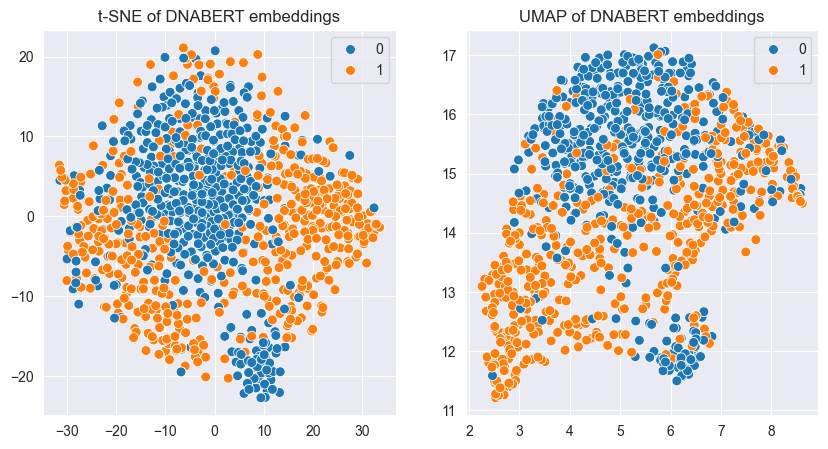

In [10]:
# Initialise t-SNE and UMAP
tsne = TSNE(n_components=2)
umap = UMAP(n_components=2)

# Use a subset for visualisation
sub = 1000
sub_train_embeddings = train_embeddings[:sub]
sub_train_labels = train_labels[:sub]

# Standardize embeddings for better visualisation
scaler = StandardScaler()
scaled_train_embeddings = scaler.fit_transform(sub_train_embeddings)

# Compute t-SNE and UMAP embeddings
tsne_train_embeddings = tsne.fit_transform(scaled_train_embeddings)
umap_train_embeddings = umap.fit_transform(scaled_train_embeddings)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(
    x=tsne_train_embeddings[:, 0], 
    y=tsne_train_embeddings[:, 1],
    hue=sub_train_labels,
    s=50,
    ax=axs[0]
    );

sns.scatterplot(
    x=umap_train_embeddings[:, 0], 
    y=umap_train_embeddings[:, 1],
    hue=sub_train_labels,
    s=50,
    ax=axs[1]
    );

axs[0].set_title("t-SNE of DNABERT embeddings");
axs[1].set_title("UMAP of DNABERT embeddings");

Nice, we see that the embeddings provided by DNA Bert are able to cluster the two classes of DNA sequences - even in only the first two components in t-SNE and UMAP projections. This is a good sign that the embeddings will be useful for the downstream task of promotor detection.

Next, we train another PromoterDetector model on the pre-trained embeddings. Unlike the `PromotorDetector` model from Section 2, we are not storing the encoder model inside the class but assume that we feed pre-trained embeddings for each DNA sequence directly into the model. Therefore, the new `PromoterDetector2` class is a regular feed-forward neural network with three hidden layers of dimension 512, 256 and 128 respectively, with ReLU activation functions and 0.1 dropout.

In [11]:
class PromoterDetector2(nn.Module):
    """Predicts the promoter sequence from the embedding of the sequence."""

    def __init__(self, 
                 hidden_dims = [512, 256, 128],
                 activation = nn.ReLU(),
                 dropout = 0.1):

        super().__init__()

        # Initialise linear layers
        dims = [768] + hidden_dims + [1]
        self.layers = nn.ModuleList([
            nn.Linear(dims[i], dims[i+1]) for i in range(len(dims) - 1)
        ])

        # Initialise dropout and activation
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, x):
        """
        Feed forward function of the classification head. Returns the logits of the classification
        of each sequence in the batch.

        Args:
            x (torch.Tensor): Tensor of sequence embeddings of shape (batch_size, embedding_size)
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, )
        """

        for layer in self.layers[:-1]:
            x = layer(x)
            x = self.dropout(x)
            x = self.activation(x)

        x = self.layers[-1](x)

        return x.squeeze()

We  define our training dataset as the combination of the obtained training embeddings and labels (i.e. the DNA sequences and whether or not they contain a promotor region). Similarly, we define our testing data for the held-out test samples.

In [12]:
# Data classes
batch_size = 128

# Create PyTorch dataset from embeddings and labels
train_labels = torch.Tensor(raw_training_data["label"].tolist())
test_labels = torch.Tensor(raw_test_data["label"].tolist())

train_dataset = TensorDataset(train_embeddings, train_labels)
test_dataset = TensorDataset(test_embeddings, test_labels)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Next, we define the training loop. We are training for only 10 epochs here, to prevent heavy overfit. Additionally, we use dropout to prevent that our network memorises the training data. We use the AdamW optimizer with a learning rate of 0.002 for training and optimise under the standard binary cross entropy loss.  In each epoch we print the training and validation loss and accuracy.

Finally, we evaluate the model on the test set using accuracy score.

In [13]:
# Training hyperparameters
epochs = 10
lr = 0.002

# Initialise model and optimiser
model = PromoterDetector2().to(device)
optimiser = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.

    for batch_embeddings, batch_labels in train_loader:
        # Zero gradients
        optimiser.zero_grad()

        # Move data to device
        batch_embeddings = batch_embeddings.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        logits = model(batch_embeddings)
        loss = criterion(logits, batch_labels)

        # Backward pass
        loss.backward()
        optimiser.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    if (epoch + 1) % 1 == 0:
        model.eval()
        total_eval_loss = 0.
        for batch_embeddings, batch_labels in test_loader:
            # Move data to device
            batch_embeddings = batch_embeddings.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            logits = model(batch_embeddings)
            loss = criterion(logits, batch_labels)

            total_eval_loss += loss.item()

        avg_eval_loss = total_eval_loss / len(test_loader)

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss {avg_train_loss:.4f} | Eval Loss {avg_eval_loss:.4f}")

Epoch [1/10] | Train Loss 0.3179 | Eval Loss 0.3215
Epoch [2/10] | Train Loss 0.2668 | Eval Loss 0.3333
Epoch [3/10] | Train Loss 0.2653 | Eval Loss 0.2690
Epoch [4/10] | Train Loss 0.2565 | Eval Loss 0.2629
Epoch [5/10] | Train Loss 0.2501 | Eval Loss 0.2772
Epoch [6/10] | Train Loss 0.2482 | Eval Loss 0.2603
Epoch [7/10] | Train Loss 0.2471 | Eval Loss 0.2549
Epoch [8/10] | Train Loss 0.2435 | Eval Loss 0.2630
Epoch [9/10] | Train Loss 0.2424 | Eval Loss 0.2549
Epoch [10/10] | Train Loss 0.2372 | Eval Loss 0.2683


In [14]:
# Evaluate performance
def validate(model, loader, device):
    model.to(device)
    y_true, y_pred = [], []
    for batch_embeddings, batch_labels in loader:
        # Move data to device
        batch_embeddings = batch_embeddings.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        logits = model(batch_embeddings)
        probs = F.sigmoid(logits)
        preds = torch.round(probs)

        y_true.extend(batch_labels.tolist())
        y_pred.extend(preds.tolist())

    y_true = torch.Tensor(y_true)
    y_pred = torch.Tensor(y_pred)

    # Compute accuracy
    acc = (preds == batch_labels).float().mean()

    return {
        "acc": acc
    }

train_results = validate(model, train_loader, device)
test_results = validate(model, test_loader, device)

print(f"Train Acc: {train_results['acc']:.4f}")
print(f"Test Acc: {test_results['acc']:.4f}")

Train Acc: 0.8548
Test Acc: 0.9375


We observe that even with a simple model and little training we are far surpassing the performance of the original `PromoterDetector` model using our custom pre-trained DNA Bert model. Using the frozen embeddings of the pre-trained DNA Bert model from the `transformers` package allows us to quickly reach high testing accuracy. This is an example of transfer learning where we use the knowledge learned from a pre-trained model to solve a different task.